<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Libraries](#Libraries) <br>
[2. Define functions](#def) <br>
[3. Use EEG + EMG + ECG to train XGboost](#all_xgboost) <br>
[4. Use ECG to train XGBoost](#ecg_xgboost) <br>

<div class="alert alert-block alert-warning">

## 1.  Libraries  <a class="anchor" name="Libraries"></a>
    
</div>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile
import pickle
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample

<div class="alert alert-block alert-warning">

## 2.  Define functions  <a class="anchor" name="def"></a>
    
</div>

In [2]:
# Function to parse the multi_entropy string and calculate the mean
def parse_multi_entropy(x):
    # Extract all the floating point numbers from the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", x)
    # Convert the extracted numbers to float and calculate the mean
    return np.mean([float(num) for num in numbers])

In [3]:
# Function to perform leave-one-out cross-validation
def loo_cv(clf, file_list, features):
    errors = []
    for i in range(len(file_list)):
        test_file = file_list[i]
        train_files = [file for j, file in enumerate(file_list) if j != i]
        
        # Read test data
        test_df = pd.read_csv(test_file)
        test_df['multi_entropy'] = test_df['multi_entropy'].apply(parse_multi_entropy)
        X_test = test_df[features]
        y_test = test_df['label'].map(label_mapping)
        
        # Read training data
        train_dfs = [pd.read_csv(train_file) for train_file in train_files]
        for train_df in train_dfs:
            train_df['multi_entropy'] = train_df['multi_entropy'].apply(parse_multi_entropy)
        
        train_df = pd.concat(train_dfs)
        X_train = train_df[features]
        y_train = train_df['label'].map(label_mapping)

        # Train the classifier 
        clf.fit(X_train.astype(float), y_train)
        y_pred = clf.predict(X_test.astype(float))
        
        errors.append(1 - accuracy_score(y_test, y_pred))
    
    return np.mean(errors)

In [4]:
# Function to perform leave-one-out cross-validation and store confusion matrices 
def loo_cv_with_confusion_matrix(clf, file_list, features):
    errors = []
    confusion_matrices = []
    
    for i in range(len(file_list)):
        test_file = file_list[i]
        train_files = [file for j, file in enumerate(file_list) if j != i]
        
        # Read test data
        test_df = pd.read_csv(test_file)
        test_df['multi_entropy'] = test_df['multi_entropy'].apply(parse_multi_entropy)
        X_test = test_df[features]
        y_test = test_df['label'].map(label_mapping)
        
        # Read and concatenate training data
        train_dfs = [pd.read_csv(train_file) for train_file in train_files]
        for train_df in train_dfs:
            train_df['multi_entropy'] = train_df['multi_entropy'].apply(parse_multi_entropy)
        train_df = pd.concat(train_dfs)
        X_train = train_df[features]
        y_train = train_df['label'].map(label_mapping)


        # Train the classifier 
        clf.fit(X_train.astype(float), y_train)
        y_pred = clf.predict(X_test.astype(float))
        
        errors.append(1 - accuracy_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
    
    # Calculate mean error and standard deviation of errors
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    
    return mean_error, std_error, confusion_matrices

In [5]:
# Function to categorize removed features
def categorize_removed_features(removed_features):
    eeg_removed = [feature for feature in removed_features if feature in eeg_features]
    ecg_removed = [feature for feature in removed_features if feature in ecg_features]
    emg_removed = [feature for feature in removed_features if feature in emg_features]
    return eeg_removed, ecg_removed, emg_removed

In [6]:
# Function to plot confusion matrix with percentages and save it
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', filename='confusion_matrix.png'):
    # Calculate percentages
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    # Create new confusion matrix with counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = '0\n0.0%'
            else:
                annot[i, j] = f'{c}\n{p:.1f}%'
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_perc_df = pd.DataFrame(cm_perc, index=labels, columns=labels)
    
    # Add Total Predicted and Total Actual
    total_actual = cm.sum(axis=1)
    total_predicted = cm.sum(axis=0)
    cm_df['Total Actual'] = total_actual
    cm_df.loc['Total Predicted'] = np.append(total_predicted, np.sum(total_predicted))
    
    total_actual_perc = total_actual / total_actual.sum() * 100
    total_predicted_perc = total_predicted / total_predicted.sum() * 100
    cm_perc_df['Total Actual'] = total_actual_perc
    cm_perc_df.loc['Total Predicted'] = np.append(total_predicted_perc, 100.0)
    
    # Prepare annotations with totals
    annot_df = cm_df.astype(str) + '\n' + cm_perc_df.round(2).astype(str) + '%'
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=annot_df, fmt='', cmap='Blues', cbar=False, xticklabels=list(cm_df.columns), yticklabels=list(cm_df.index))
    
    # Highlight the Total columns and rows with white background
    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)
    plt.gca().add_patch(plt.Rectangle((cm.shape[1], 0), 1, cm.shape[0], fill=True, facecolor='white', edgecolor='black', lw=1))
    plt.gca().add_patch(plt.Rectangle((0, cm.shape[0]), cm.shape[1], 1, fill=True, facecolor='white', edgecolor='black', lw=1))
    
    # Set title and labels
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    
    # Save the figure
    plt.savefig(filename)
    plt.show()

In [7]:
# Function to calculate average F1 score and accuracy
def calculate_metrics(confusion_matrices):
    all_f1_weighted = []
    all_f1_macro = []
    all_accuracies = []

    for cm in confusion_matrices:
        true_labels = []
        predicted_labels = []
        
        for actual_class in range(len(cm)):
            for predicted_class in range(len(cm[actual_class])):
                true_labels.extend([actual_class] * cm[actual_class][predicted_class])
                predicted_labels.extend([predicted_class] * cm[actual_class][predicted_class])
        
        f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
        f1_macro = f1_score(true_labels, predicted_labels, average='macro')
        accuracy = accuracy_score(true_labels, predicted_labels)

        all_f1_weighted.append(f1_weighted)
        all_f1_macro.append(f1_macro)
        all_accuracies.append(accuracy)

    average_f1_weighted = np.mean(all_f1_weighted)
    average_f1_macro = np.mean(all_f1_macro)
    average_accuracy = np.mean(all_accuracies)

    return average_f1_weighted, average_f1_macro, average_accuracy

In [8]:
# Define feature categories
eeg_features = [
    'PFD', 'DFA', 'sh_entropy', 'multi_entropy', 'sample_entropy', 'approx_entropy',
    'absolute_delta_power', 'relative_delta_power', 'absolute_theta_power', 'relative_theta_power',
    'absolute_alpha_power', 'relative_alpha_power', 'absolute_belta_power', 'relative_belta_power'
]


ecg_features = [
    'NNmean', 'NNmedian', 'NNmode', 'NNvariance', 'NNskew', 'NNkurt', 'NNiqr', 
    'SDNN', 'RMSSD', 'pnn1', 'pnn2', 'pnn3', 'pnn4', 'pnn5', 'btsdet',
    'ulf', 'vlf', 'lf', 'hf', 'lfhf', 'ttlpwr', 'ac', 'dc', 'SampEn', 'ApEn'
]

emg_features = [
    'amplitude_mean', 'amplitude_median', 'amplitude_rms', 'amplitude_std', 'amplitude_max',
    'low_power', 'med_power', 'high_power', 'low_rel_power', 'mid_rel_power', 'high_rel_power',
    'dominant_frequency', 'duration'
]

<div class="alert alert-block alert-warning">

## 3.  Use EEG + EMG + ECG to train XGboost  <a class="anchor" name="all_xgboost"></a>
    
</div>


In [9]:
# Combine all features
all_features = eeg_features + ecg_features + emg_features

# Define directories and feature categories
base_dir = "Fake_merge_data"
file_list = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(".csv")]

# Map the labels to positive integers
label_mapping = {-1: 0, 0: 1, 1: 2}

In [10]:
# Initialize classifiers for XGBoost
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', objective='multi:softmax', num_class=3)

# Perform RFE manually with a progress bar for XGBoost
min_features_to_select = 1
step = 1

# Combine all data for initial feature selection
combined_df = pd.concat([pd.read_csv(file) for file in file_list])
combined_df['multi_entropy'] = combined_df['multi_entropy'].apply(parse_multi_entropy)
X_combined = combined_df[all_features]
y_combined = combined_df['label'].map(label_mapping)

# Initial set of features for XGBoost
remaining_features_xgb = all_features[:]
best_features_xgb = remaining_features_xgb[:]
best_error_xgb = float('inf')

In [11]:
pbar_xgb = tqdm(total=len(remaining_features_xgb) - min_features_to_select, desc="RFECV Progress for XGBoost")

while len(remaining_features_xgb) > min_features_to_select:
    # Perform leave-one-out CV for the current set of features
    current_error_xgb = loo_cv(xgb_clf, file_list, remaining_features_xgb)
    
    # Update the best set of features if the current error is lower
    if current_error_xgb < best_error_xgb:
        best_error_xgb = current_error_xgb
        best_features_xgb = remaining_features_xgb[:]
    
    # Remove the least important feature
    importances_xgb = xgb_clf.fit(X_combined[remaining_features_xgb], y_combined).feature_importances_
    
    least_important_feature_xgb = remaining_features_xgb[np.argmin(importances_xgb)]
    remaining_features_xgb.remove(least_important_feature_xgb)
    
    pbar_xgb.update(step)

pbar_xgb.close()

print(f'XGBoost selected features: {list(best_features_xgb)}')

RFECV Progress for XGBoost: 100%|██████████████████████████████████████████████████████| 51/51 [01:50<00:00,  2.17s/it]

XGBoost selected features: ['multi_entropy', 'absolute_delta_power', 'absolute_belta_power', 'NNmean', 'RMSSD', 'btsdet', 'lfhf', 'amplitude_median', 'low_power', 'high_power', 'low_rel_power', 'high_rel_power']


In [12]:
# Determine removed features for XGBoost
removed_features_xgb = set(all_features) - set(best_features_xgb)
print(f'XGBoost Removed features: {list(removed_features_xgb)}')

XGBoost Removed features: ['ac', 'sample_entropy', 'PFD', 'relative_delta_power', 'SDNN', 'vlf', 'sh_entropy', 'duration', 'ulf', 'ttlpwr', 'absolute_alpha_power', 'amplitude_std', 'mid_rel_power', 'amplitude_mean', 'relative_belta_power', 'absolute_theta_power', 'amplitude_rms', 'NNmedian', 'relative_alpha_power', 'NNmode', 'amplitude_max', 'lf', 'ApEn', 'NNkurt', 'pnn5', 'DFA', 'SampEn', 'dc', 'med_power', 'pnn4', 'relative_theta_power', 'pnn1', 'pnn2', 'NNiqr', 'NNskew', 'pnn3', 'NNvariance', 'approx_entropy', 'hf', 'dominant_frequency']


In [13]:
# Perform Random Search for best hyperparameters for XGBoost
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=50, scoring='accuracy', verbose=1, random_state=42)
random_search.fit(X_combined[best_features_xgb], y_combined)

best_xgb_clf = random_search.best_estimator_
print(f'Best XGBoost parameters: {random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}


In [14]:
# Ensure the directory for saving the pickle file exists
pkl_dir = 'pkl_file'
if not os.path.exists(pkl_dir):
    os.makedirs(pkl_dir)  # Create the directory if it doesn't exist

# Evaluate XGBoost performance with the selected features and best hyperparameters
print("Evaluating selected features for XGBoost with best hyperparameters...")
xgb_all_mean_error, xgb_all_std_error, xgb_all_confusion_matrices = loo_cv_with_confusion_matrix(best_xgb_clf, file_list, best_features_xgb)
print(f'XGBoost Mean Validation Error with selected features: {xgb_all_mean_error}')
print(f'XGBoost Standard Deviation of Validation Error with selected features: {xgb_all_std_error}')

# Save the confusion matrices to a pickle file
pkl_file_path = os.path.join(pkl_dir, 'xgb_confusion_matrices.pkl')
with open(pkl_file_path, 'wb') as f:
    pickle.dump(xgb_all_confusion_matrices, f)

print(f"Confusion matrices saved to {pkl_file_path}")

Evaluating selected features for XGBoost with best hyperparameters...
XGBoost Mean Validation Error with selected features: 0.11904761904761907
XGBoost Standard Deviation of Validation Error with selected features: 0.20342866060279838
Confusion matrices saved to pkl_file\xgb_confusion_matrices.pkl


Feature ranking (XGBoost):
RMSSD: 0.16482584178447723
multi_entropy: 0.13793602585792542
NNmean: 0.13506649434566498
btsdet: 0.1142776757478714
high_power: 0.10856375098228455
absolute_belta_power: 0.07994747906923294
lfhf: 0.05133499205112457
absolute_delta_power: 0.05081763118505478
low_rel_power: 0.04814102128148079
high_rel_power: 0.041476428508758545
amplitude_median: 0.03679289668798447
low_power: 0.030819712206721306


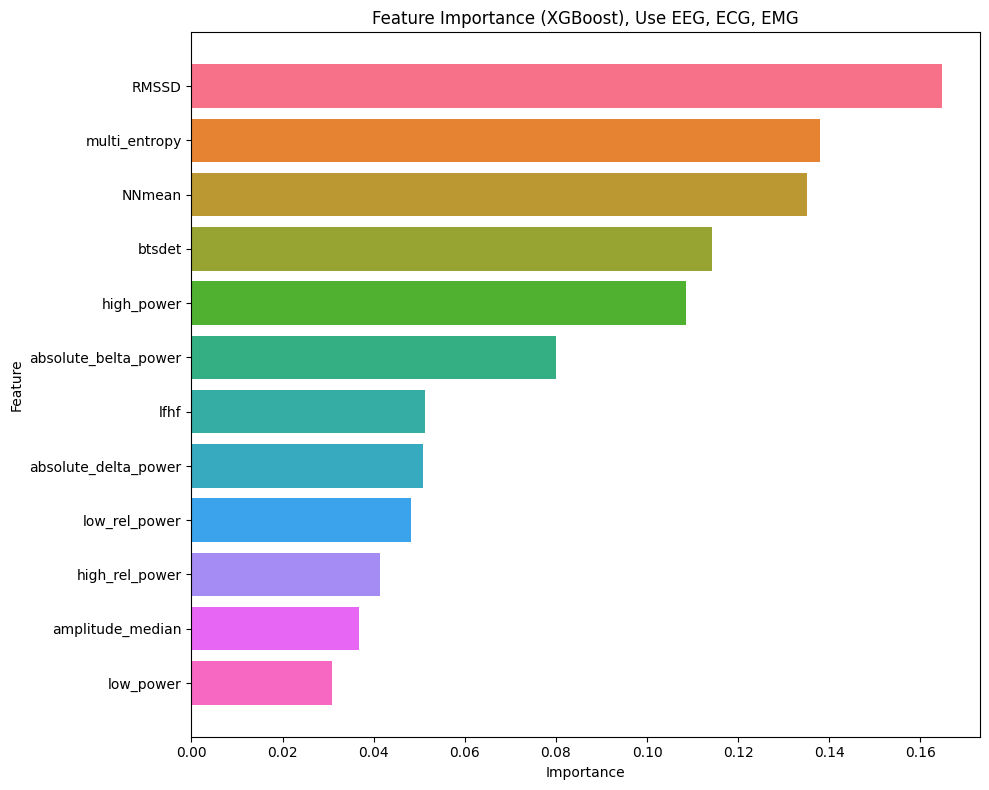

In [15]:
# Feature importance ranking and plotting for XGBoost
importances_xgb = best_xgb_clf.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_ranking_xgb = {best_features_xgb[i]: importances_xgb[i] for i in indices_xgb}

print("Feature ranking (XGBoost):")
for feature, importance in feature_ranking_xgb.items():
    print(f"{feature}: {importance}")

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
plt.title("Feature Importance (XGBoost), Use EEG, ECG, EMG")
colors = sns.color_palette('husl', len(best_features_xgb))
plt.barh(range(len(best_features_xgb)), importances_xgb[indices_xgb], color=colors, align='center')
plt.yticks(range(len(best_features_xgb)), [best_features_xgb[i] for i in indices_xgb])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

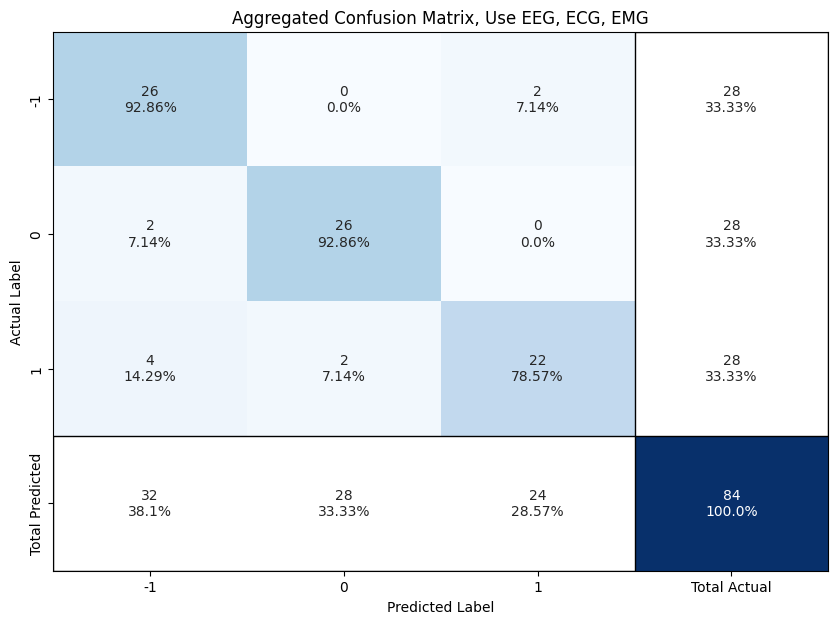

Average F1 Score (Weighted): 0.8452
Average F1 Score (Macro): 0.8452
Average Accuracy: 0.8810


In [31]:
#### Load the confusion matrices from the pickle file
with open("pkl_file/xgb_confusion_matrices.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)
labels = [-1, 0, 1]

# Ensure the directory for saving the figure file exists
figure_dir = 'Figures'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)  # Create the directory if it doesn't exist
    
# Plot the aggregated confusion matrix
plot_confusion_matrix(aggregated_cm, labels, title='Aggregated Confusion Matrix, Use EEG, ECG, EMG', filename='Figures/xgb_confusion_matrices.png')

# Calculate and print the average F1 scores and accuracy
average_f1_weighted, average_f1_macro, average_accuracy = calculate_metrics(confusion_matrices)
print(f'Average F1 Score (Weighted): {average_f1_weighted:.4f}')
print(f'Average F1 Score (Macro): {average_f1_macro:.4f}')
print(f'Average Accuracy: {average_accuracy:.4f}')

In [17]:
aggregated_cm

array([[26,  0,  2],
       [ 2, 26,  0],
       [ 4,  2, 22]], dtype=int64)

<div class="alert alert-block alert-warning">

## 4.  Use EEG to train XGboost  <a class="anchor" name="ecg_xgboost"></a>
    
</div>


In [18]:
# only ECG feature
selected_features = ecg_features

# Separate features and target
X = combined_df[selected_features]
y = combined_df['label'].map(label_mapping)

# Initialize classifiers for XGBoost
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', objective='multi:softmax', num_class=3)

# Perform RFE manually with a progress bar for XGBoost
remaining_features_xgb = selected_features[:]
best_features_xgb = remaining_features_xgb[:]
best_error_xgb = float('inf')

In [19]:
pbar_xgb = tqdm(total=len(remaining_features_xgb) - min_features_to_select, desc="RFECV Progress for XGBoost")

while len(remaining_features_xgb) > min_features_to_select:
    # Perform leave-one-out CV for the current set of features
    current_error_xgb = loo_cv(xgb_clf, file_list, remaining_features_xgb)
    
    # Update the best set of features if the current error is lower
    if current_error_xgb < best_error_xgb:
        best_error_xgb = current_error_xgb
        best_features_xgb = remaining_features_xgb[:]
    
    # Remove the least important feature
    importances_xgb = xgb_clf.fit(X[remaining_features_xgb], y).feature_importances_
    least_important_feature_xgb = remaining_features_xgb[np.argmin(importances_xgb)]
    remaining_features_xgb.remove(least_important_feature_xgb)
    
    pbar_xgb.update(step)

pbar_xgb.close()

print(f'XGBoost selected features: {list(best_features_xgb)}')

RFECV Progress for XGBoost: 100%|██████████████████████████████████████████████████████| 24/24 [00:48<00:00,  2.02s/it]

XGBoost selected features: ['NNmean', 'NNvariance', 'btsdet']


In [20]:
# Determine removed features for XGBoost
removed_features_xgb = set(X.columns) - set(best_features_xgb)
print(f'XGBoost Removed features: {list(removed_features_xgb)}')

XGBoost Removed features: ['NNmedian', 'NNmode', 'ac', 'lf', 'ApEn', 'NNkurt', 'pnn5', 'RMSSD', 'vlf', 'SDNN', 'SampEn', 'dc', 'ulf', 'hf', 'pnn4', 'pnn1', 'pnn2', 'NNiqr', 'NNskew', 'lfhf', 'pnn3', 'ttlpwr']


In [21]:
print(f'XGBoost selected features: {list(best_features_xgb)}')

XGBoost selected features: ['NNmean', 'NNvariance', 'btsdet']


In [22]:
# Hyperparameter tuning with RandomizedSearchCV for XGBoost
param_dist_xgb = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=param_dist_xgb, n_iter=50, scoring='accuracy', cv=len(file_list)-1, verbose=1, random_state=42)
random_search_xgb.fit(X[best_features_xgb], y)

best_xgb_clf = random_search_xgb.best_estimator_
print(f'Best XGBoost parameters: {random_search_xgb.best_params_}')

Fitting 13 folds for each of 50 candidates, totalling 650 fits
Best XGBoost parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}


Feature ranking (XGBoost):
btsdet: 0.3875042200088501
NNmean: 0.3316504955291748
NNvariance: 0.28084519505500793


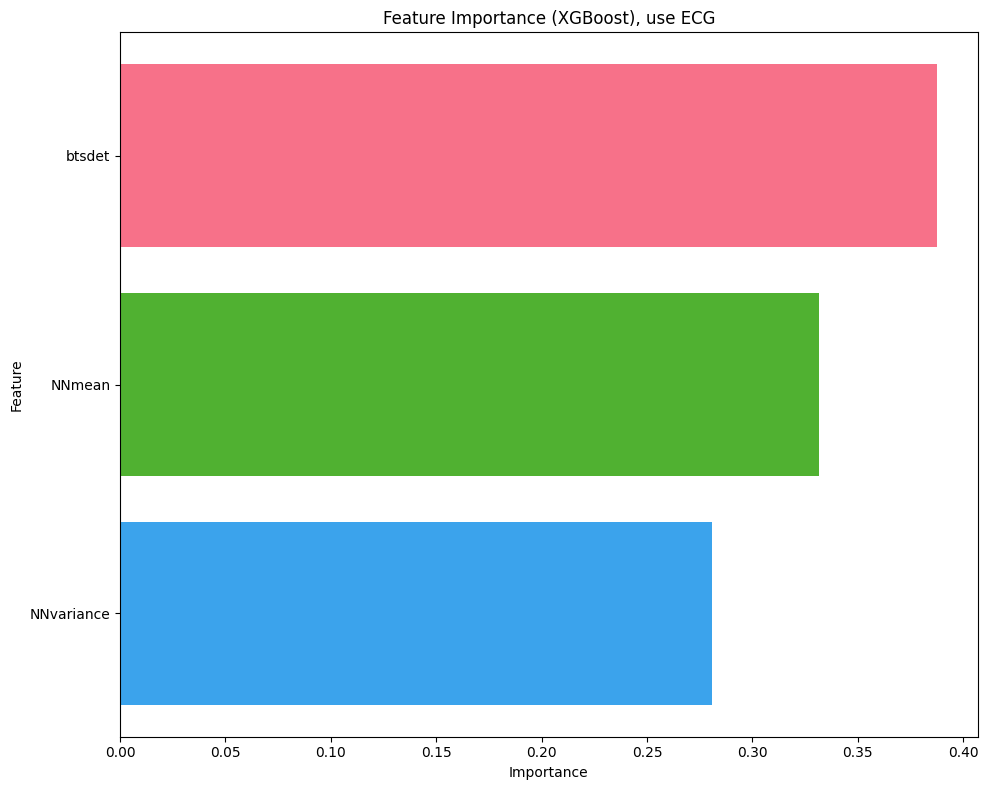

In [23]:
# Feature importance ranking and plotting for XGBoost
importances_xgb = best_xgb_clf.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_ranking_xgb = {best_features_xgb[i]: importances_xgb[i] for i in indices_xgb}

print("Feature ranking (XGBoost):")
for feature, importance in feature_ranking_xgb.items():
    print(f"{feature}: {importance}")

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
plt.title("Feature Importance (XGBoost), use ECG")
colors = sns.color_palette('husl', len(best_features_xgb))
plt.barh(range(len(best_features_xgb)), importances_xgb[indices_xgb], color=colors, align='center')
plt.yticks(range(len(best_features_xgb)), [best_features_xgb[i] for i in indices_xgb])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

In [24]:
# Evaluate the selected features with the best hyperparameters for XGBoost
print("Evaluating selected features for XGBoost with best hyperparameters...")
xgb_ecg_mean_error, xgb_ecg_std_error, xgb_confusion_matrices_ecg = loo_cv_with_confusion_matrix(best_xgb_clf, file_list, best_features_xgb)
print(f'XGBoost Mean Validation Error with selected features: {xgb_ecg_mean_error}')
print(f'XGBoost Standard Deviation of Validation Error with selected features: {xgb_ecg_std_error}')

with open('pkl_file/xgb_confusion_matrices_no_EEG_EMG.pkl', 'wb') as f:
    pickle.dump(xgb_confusion_matrices_ecg, f)

Evaluating selected features for XGBoost with best hyperparameters...
XGBoost Mean Validation Error with selected features: 0.13095238095238096
XGBoost Standard Deviation of Validation Error with selected features: 0.1565826956900703


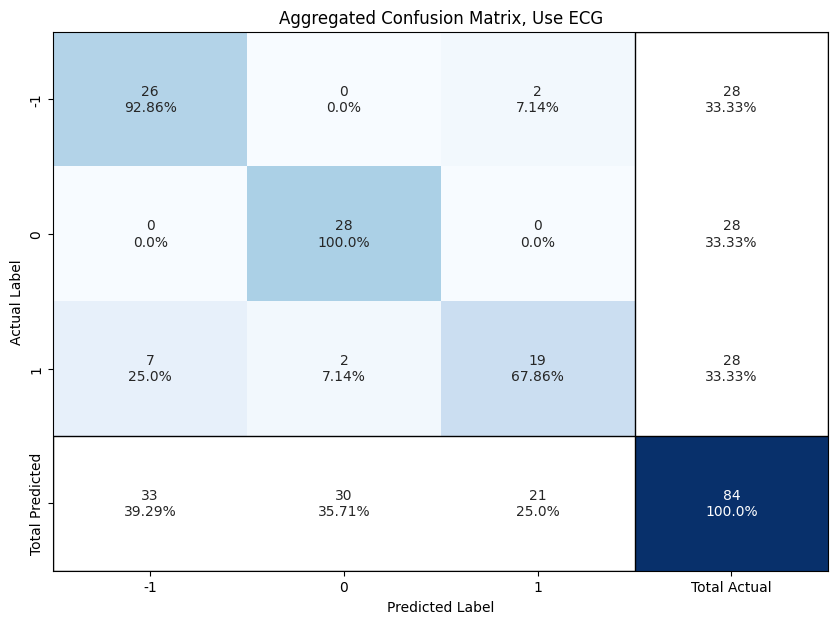

Average F1 Score (Weighted): 0.8286
Average F1 Score (Macro): 0.8286
Average Accuracy: 0.8690


In [32]:
# Load the confusion matrices from the pickle file
with open("pkl_file/xgb_confusion_matrices_no_EEG_EMG.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)
labels = [-1, 0, 1]

# Plot the aggregated confusion matrix
plot_confusion_matrix(aggregated_cm, labels, title='Aggregated Confusion Matrix, Use ECG', filename='Figures/xgb_confusion_matrices_no_EEG_EMG.png')

# Calculate and print the average F1 scores and accuracy
average_f1_weighted, average_f1_macro, average_accuracy = calculate_metrics(confusion_matrices)
print(f'Average F1 Score (Weighted): {average_f1_weighted:.4f}')
print(f'Average F1 Score (Macro): {average_f1_macro:.4f}')
print(f'Average Accuracy: {average_accuracy:.4f}')